
# Network Science (HS21)
## Assignment 7

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [153]:
import networkx as nx
import numpy as np
from numpy.typing import ArrayLike
from typing import Tuple, List
import matplotlib.pyplot as plt 
import seaborn as sns

In [296]:
def compute_eigen(data: ArrayLike) -> Tuple[float, float]:
    return np.linalg.eig(data)

def marcenko_pasture_law(Q: float) -> ArrayLike:

    sigma = 1
    lambda_max = sigma**2 * (1 + (1 / Q) + 2 * np.sqrt(1 / Q))
    lambda_min = sigma**2 * (1 + (1 / Q) - 2 * np.sqrt(1 / Q))
    space = np.linspace(lambda_min,lambda_max,50)
    print(f"Q: {Q}")
    print(f"lambda max: {lambda_max}, lambda min: {lambda_min}")

    p = Q / (2 * np.pi * sigma**2) * np.sqrt((lambda_max - space) * (space - lambda_min)) / space

    return space,p

def plot_hist(eigen, marcenko_space,marcenko, label):
    print(f"found eigenvalues greater than 5: {eigen[eigen>5]}")
    marcenko_scaler =  np.max(marcenko_space) - np.min(marcenko_space)
    
    if marcenko_scaler>=1:
        marcenko/=marcenko_scaler
    else:
        marcenko*=marcenko_scaler
    bins = np.arange(0, np.max(eigen),1)
    sns.histplot(eigen, label="eigen",stat="density", bins=bins)
    plt.plot(marcenko_space,marcenko, label="marcenko")
    plt.title(f"Eigen hist with marcenko_superimposed for {label}")
    plt.xlabel("p(lambda)")
    plt.ylabel("lambda")
    plt.legend()
    plt.show()

    increase = 0.5
    eigen = eigen[eigen<5]
    bins = np.arange(0,5,increase)
    sns.histplot(eigen/increase, bins=bins, stat="density", label="eigen")
    plt.plot(marcenko_space,marcenko, label="marcenko")
    plt.title(f"Eigen hist with marcenko_superimposed for {label} focused on lambda<5")
    plt.ylabel("p(lambda)")
    plt.xlabel("lambda")
    plt.legend()
    plt.show()

def denoise_correlation_matrix(values: ArrayLike, vectors: ArrayLike, Q) -> ArrayLike:
    sigma = 1
    lambda_max = sigma**2 * (1 + (1 / Q) + 2 * np.sqrt(1 / Q))
    values[values<lambda_max] = 0.5
    
    values = values / np.sum(values)
    D = np.diag(values)


    denoised = vectors @ D @ np.linalg.inv(vectors)
    
    denoised_diag = 1 / np.sqrt(np.diag(denoised))
    D = np.zeros(denoised.shape)
    np.fill_diagonal(D,denoised_diag)

    rescaled_denoised = D @ denoised @ D
    print(rescaled_denoised.shape)
    return rescaled_denoised

def solve_s01(data: ArrayLike, Q: float,label: str):
    values, vectors = compute_eigen(data)
    
    space,p = marcenko_pasture_law(Q)
    plot_hist(values, space,p, label)
    
    denoised = denoise_correlation_matrix(values, vectors, Q)
    return denoised


In [130]:
h1 = np.load("data/cormat_1h.npy")
m1 = np.load("data/cormat_1m.npy")
with open("data/stocknames.txt", "r") as f:
    stocknames = [name.replace("\n","") for name in f.readlines()]

Q: 200.8969
lambda max: 1.146082994368982, lambda min: 0.8638723608405807
found eigenvalues greater than 5: [30.15967999]


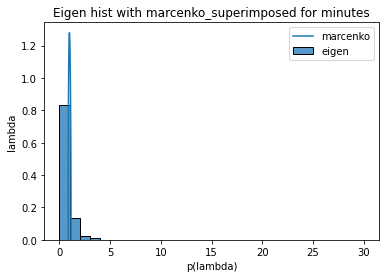

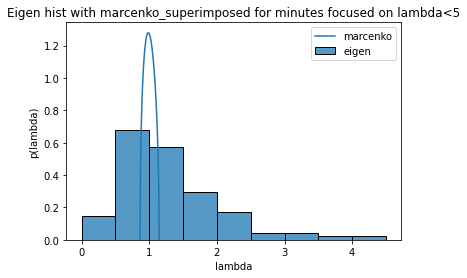

(97, 97)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Q: 3.6289
lambda max: 2.3254524463713677, lambda min: 0.22567875041002616
found eigenvalues greater than 5: [31.02783574  6.11462818]


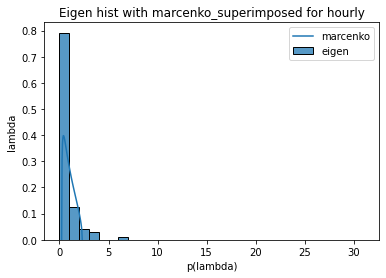

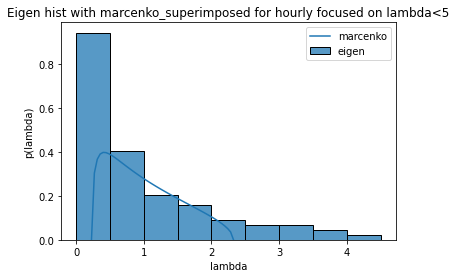

(97, 97)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [297]:
denoised_min = solve_s01(m1, 200.8969,"minutes")
denoised_hour = solve_s01(h1, 3.6289,"hourly")


In [223]:
denoised_hour.shape

(97, 97)

# A07.2

In [274]:
from networkx.algorithms.tree.mst import minimum_spanning_tree

In [293]:
def plot_stock_scatter(minutes: ArrayLike, hours: ArrayLike):
    plt.scatter(minutes, hours)
    plt.title("Denoised")
    plt.xlabel("denoised minutes corr matrix")
    plt.ylabel("denoised hour corr matrix")
    plt.show()

def create_minimum_spanning_tree(data: ArrayLike, labels: List[str]):
    distance = np.sqrt(2*(1-data))
    graph = nx.from_numpy_array(distance)
    nx.set_node_attributes(graph, values=labels, name="ticker")
    return minimum_spanning_tree(graph,"ticker")
    #degrees = nx.degree(mst)
    #return degrees

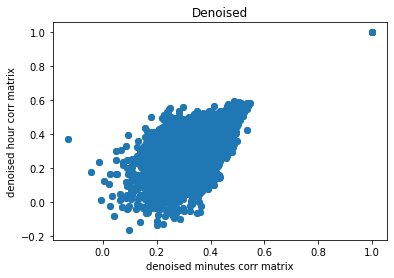

In [298]:
plot_stock_scatter(denoised_min,denoised_hour)

/tmp/ipykernel_649517/1687864447.py:9: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt(2*(1-data))


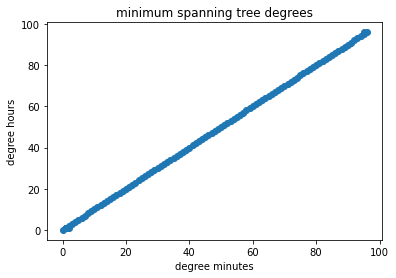

In [295]:
mst_min = create_minimum_spanning_tree(denoised_min,stocknames)

mst_hour = create_minimum_spanning_tree(denoised_hour, stocknames)
degrees_min = nx.degree(mst_min)
degrees_hour = nx.degree(mst_hour)
plt.scatter(degrees_min,degrees_hour)
plt.title("minimum spanning tree degrees")
plt.xlabel("degree minutes")
plt.ylabel("degree hours")
plt.show()

# A07.3

## 3.1
Yes
We can't really see it on the histogram plots, but we printed all eigenvalues > 5. For the minutes the market mode corresponds to the lambda at 30.15967999 and for the hours the market mode corresponds to the lambda at 31.02783574.

## 3.2

## 3.3

## 3.4